# Rozwiązywanie zadania klasyfikacji
## [Zadanie](http://pages.mini.pw.edu.pl/~karwowskij/mioad/lab-sieci.html#org6058800)



Zaimplementować funkcję softmax dla warstwy wyjściowej sieci neuronowej. Sprawdzić szybkość i skuteczność w wariancie, gdy sieć używa funkcji softmax na ostatniej warstwie i gdy jest użyta zwykła funkcja aktywacji. Softmax wymaga też odpowiednich zmian w algorytmie uczenia, uwzględniających pochodną fukcji.

Przeprowadzić eksperymenty na zbiorach:
- rings3-regular,
- easy,
- xor3.

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
#### Miscellaneous classes

class Sigmoid:
    @staticmethod
    def activate(z):
        return 1 / (1 + np.exp(-z))

    @staticmethod
    def derivative(z):
        return Sigmoid.activate(z) * (1 - Sigmoid.activate(z))
    
class Linear:
    @staticmethod
    def activate(z):
        return z

    @staticmethod
    def derivative(z):
        return 1  

class MSECostFunction:
    @staticmethod
    def cost(y_true, y_pred):
        return np.mean((y_pred - y_true) ** 2)

    @staticmethod
    def derivative(y_true, y_pred):
        return y_pred - y_true
    
class SoftMax:
    @staticmethod
    def activate(z):
        e_x = np.exp(z - np.max(z))
        return e_x / e_x.sum(axis=0, keepdims=True)
    @staticmethod
    def derivative(z):
        return 1

### Neural network initialization

In [3]:
class MLP:

    def __init__(self, layers, initial_dist, activation_functions, cost_function, softmax):
        
        """
        Presence of at least one hidden layer is an accompanying assumption        

        Takes:        
        layers - list of numbers of neurons in subsequent layers
        activation_functions - list of names of functions ie ('sigmoid', 'linear')

        Remarks: 
            - Length of layers list should be equal to length of activation_functions list + 1 
            - The biases and weights for the network are initialized randomly, using continuous uniform 
              distribution with certain bounds between 0 and 1 or -1 and 1 or Gaussian distribution with mean 0, 
              and variance 1.
        """

        self.layers = layers
        self.n_layers = len(layers)
        self.weights = []
        self.biases = []
        self.weights_bias_init(initial_dist)

        self.activation_functions = []
        self.activation_functions_grad = []
        
        for fun in activation_functions:
            self.activation_functions.append(np.vectorize(fun.activate))
            self.activation_functions_grad.append(np.vectorize(fun.derivative))

        self.cost_function = cost_function
        self.softmax = softmax

        if softmax:
            self.activation_functions[-1] = activation_functions[-1].activate
            
    def weights_bias_init(self, initial_dist):

        if initial_dist == "gaussian":
            self.biases = [np.random.normal(size=(y, 1)) for y in self.layers[1:]]
            self.weights = [np.random.normal(size=(y, x)) for x, y in zip(self.layers[:-1], self.layers[1:])]

        elif initial_dist == "uniform":
            self.biases = [np.random.uniform(-1, 1, size=(y, 1)) for y in self.layers[1:]]
            self.weights = [np.random.uniform(-1, 1, size=(y, x)) for x, y in zip(self.layers[:-1], self.layers[1:])]
        else:
            self.biases = [np.random.uniform(0, 1, size=(y, 1)) for y in self.layers[1:]]
            self.weights = [np.random.uniform(0, 1, size=(y, x)) for x, y in zip(self.layers[:-1], self.layers[1:])]

    def forward(self, x):
        """
        Returns the output of the network if x is an input.
        """
        flat_values = []
        activation_values = [np.copy(x)]
        for w, b, f in zip(self.weights, self.biases, self.activation_functions):
            flat_values.append(w.dot(activation_values[-1]) + b)
            activation_values.append(f(flat_values[-1]))
        return (flat_values, activation_values)

    def backprop(self, x_batch, y_batch):
        """
        Function performing backpropagation
        Returns nabla_b and nabla_w representing the
        derivatives by weights and biases respectively. 
        nabla_b and nabla_w are calculated layer-by-layer.
        """ 
        (flat_values, activation_values) = self.forward(x_batch)
        errors = [None] * len(self.weights)
        
        if not self.softmax:
            errors[-1] = (-self.cost_function.derivative(y_batch, activation_values[-1])) * self.activation_functions_grad[-1](flat_values[-1])
        else:
            errors[-1] = y_batch - activation_values[-1]
            
        for i in reversed(range(len(errors) - 1)):
            errors[i] = self.weights[i + 1].T.dot(errors[i + 1]) * self.activation_functions_grad[i](flat_values[i])
        batch_size = y_batch.shape[1]
        d_b = [e.dot(np.ones((batch_size, 1))) / float(batch_size) for e in errors]
        d_w = [e.dot(activation_values[i].T) / float(batch_size) for i, e in enumerate(errors)]
        return (d_w, d_b)
    
    def predict(self, x):
        return self.forward(x.T)[1][-1].T

    def train(self, x, y, batches_num = 10, epochs = 100, eta = 10 ** (-3)):
        """
        Updates weights and biases based on the output using backpropagation.
        
        The version with the update of the scales after the presentation 
        of all patterns and the version with the update after the presentation
        of subsequent portions (batch) was performed within one function. 
        To get the first variant of operation as batch size the number of all
        observations should be given.
        """
        for epoch in range(epochs):
            shuffled_indexes = np.random.permutation(x.shape[0])
            updated_x = x.copy()[shuffled_indexes]
            updated_y = y.copy()[shuffled_indexes]

            updated_x = np.array_split(updated_x, batches_num)
            updated_y = np.array_split(updated_y, batches_num)

            for batch_num in range(batches_num):
                x_batch = updated_x[batch_num].T
                y_batch = updated_y[batch_num].T
                d_w, d_b = self.backprop(x_batch, y_batch)
                self.weights = [w + eta * dw for w, dw in zip(self.weights, d_w)]
                self.biases = [b + eta * db for b, db in zip(self.biases, d_b)]

    def trainWithMomentum(self, x, y, lambda_val, batches_num = 10, epochs = 100, eta = 10 ** (-3)):
        for epoch in range(epochs):
            momentum_b = [np.zeros(b.shape) for b in self.biases]
            momentum_w = [np.zeros(w.shape) for w in self.weights]

            shuffled_indexes = np.random.permutation(x.shape[0])
            updated_x = x.copy()[shuffled_indexes]
            updated_y = y.copy()[shuffled_indexes]

            updated_x = np.array_split(updated_x, batches_num)
            updated_y = np.array_split(updated_y, batches_num)

            for batch_num in range(batches_num):
                x_batch = updated_x[batch_num].T
                y_batch = updated_y[batch_num].T
                d_w, d_b = self.backprop(x_batch, y_batch)

                momentum_b = [db + mb * lambda_val for mb, db in zip(momentum_b, d_b)]
                momentum_w = [dw + mw * lambda_val for mw, dw in zip(momentum_w, d_w)]

                self.biases = [b + mb * eta for b, mb in zip(self.biases, momentum_b)]
                self.weights = [w + mw * eta for w, mw in zip(self.weights, momentum_w)]

    def trainWithRMSProp(self, x, y, beta, batches_num = 10, epochs = 100, eta = 10 ** (-3)):
        for epoch in range(epochs):
            grad_b = [np.zeros(b.shape) for b in self.biases]
            grad_w = [np.zeros(w.shape) for w in self.weights]

            shuffled_indexes = np.random.permutation(x.shape[0])
            updated_x = x.copy()[shuffled_indexes]
            updated_y = y.copy()[shuffled_indexes]

            updated_x = np.array_split(updated_x, batches_num)
            updated_y = np.array_split(updated_y, batches_num)

            for batch_num in range(batches_num):
                x_batch = updated_x[batch_num].T
                y_batch = updated_y[batch_num].T
                d_w, d_b = self.backprop(x_batch, y_batch)

                grad_b = [(1 - beta) * np.square(db) + beta * gb for gb, db in zip(grad_b, d_b)]
                grad_w = [(1 - beta) * np.square(dw) + beta * gw for gw, dw in zip(grad_w, d_w)]

                self.biases = [b + np.divide(db, np.sqrt(gb) + 10e-8) * eta for b, gb, db in zip(self.biases, grad_b, d_b)]
                self.weights = [w + np.divide(dw, np.sqrt(gw) + 10e-8) * eta for w, gw, dw in zip(self.weights, grad_w, d_w)]
       

## 1. Easy dataset

In [4]:
easy_train = pd.read_csv("../data/mio1/classification/easy-training.csv")
easy_test = pd.read_csv("../data/mio1/classification/easy-test.csv")

# universal parameter setting
activation_functions = [Sigmoid,SoftMax]

n_layers = [2, 10, 2]
number_of_batches = 1
upper_epoch_bound = 100

eta = 0.01
accuracy_scores = [[], []]

In [5]:
# data preprocessing
x_test = easy_test[["x", "y"]].to_numpy()
x_train = easy_train[["x", "y"]].to_numpy()

y_test = easy_test["c"] * 1
n_values = np.max(y_test) + 1
y_test = np.eye(n_values)[y_test.T]

y_train = easy_train["c"] * 1
n_values = np.max(y_train) + 1
y_train = np.eye(n_values)[y_train.T]

In [6]:
# Neural network with softmax performance 

easy = MLP(n_layers, "gaussian", activation_functions, MSECostFunction, True)

initial_weights = easy.weights.copy()
initial_biases = easy.biases.copy()

idx = 0

while idx < upper_epoch_bound:

    easy.trainWithRMSProp(x = x_train, y = y_train, eta = eta, epochs = 1, batches_num = number_of_batches, beta = 0.90)

    prediction = easy.predict(x_test)
    prediction = np.argmax(prediction, axis = 1)
    
    accuracy_scores[0].append(accuracy_score(np.argmax(y_test, axis = 1), prediction))
    idx += 1

In [7]:
# Neural network without softmax performance 

activation_functions = [Sigmoid, Linear]
easy = MLP(n_layers, "gaussian", activation_functions, MSECostFunction, False)

easy.weights = initial_weights
easy.biases = initial_biases

epoch_number = 0

while epoch_number < upper_epoch_bound:

    easy.trainWithRMSProp(x = x_train, y = y_train, eta = eta, epochs = 1, batches_num = number_of_batches, beta = 0.90)

    prediction = easy.predict(x_test)
    prediction = np.argmax(prediction, axis = 1)
    
    accuracy_scores[1].append(accuracy_score(np.argmax(y_test, axis = 1), prediction))
    epoch_number += 1

### Results comparison

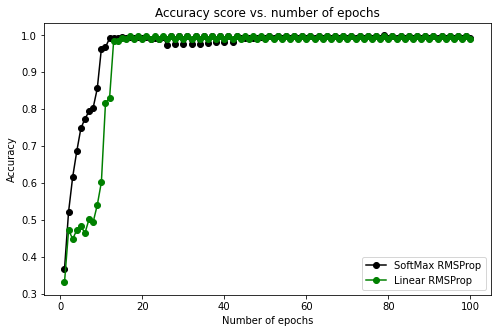

In [8]:
fig = plt.figure(figsize = (8, 5))
ax1 = fig.add_subplot(111)
x_epochs = [i for i in range(1, upper_epoch_bound + 1, 1)]
ax1.plot(x_epochs, accuracy_scores[0], '-ok', label="SoftMax RMSProp")
ax1.plot(x_epochs, accuracy_scores[1], '-og', label="Linear RMSProp")
plt.legend(loc="lower right")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy score vs. number of epochs")
plt.show()

## 2. Rings3-regular dataset

In [9]:
rings3_train = pd.read_csv("../data/mio1/classification/rings3-regular-training.csv")
rings3_test = pd.read_csv("../data/mio1/classification/rings3-regular-test.csv")

# universal parameter setting
activation_functions = [Sigmoid, Sigmoid, SoftMax]

n_layers = [2, 10, 3]
number_of_batches = 10
upper_epoch_bound = 1000
eta = 0.005

In [10]:
# Data preprocessing
x_test = rings3_test[["x", "y"]].to_numpy()
x_train = rings3_train[["x", "y"]].to_numpy()

y_test = rings3_test["c"] * 1
n_values = np.max(y_test) + 1
y_test = np.eye(n_values)[y_test.T]

y_train = rings3_train["c"] * 1
n_values = np.max(y_train) + 1
y_train = np.eye(n_values)[y_train.T]

In [11]:
# Neural network with softmax performance 

rings3 = MLP(n_layers, "default", activation_functions, MSECostFunction, True)

initial_weights = rings3.weights.copy()
initial_biases = rings3.biases.copy()

accuracy_scores = [[], []]

idx = 0

while idx < upper_epoch_bound:

    rings3.trainWithRMSProp(x = x_train, y = y_train, eta = eta, epochs = 1, batches_num = number_of_batches, beta = 0.9)

    prediction = rings3.predict(x_test)
    prediction = np.argmax(prediction, axis = 1)
    
    accuracy_scores[0].append(accuracy_score(np.argmax(y_test, axis = 1), prediction))
    idx += 1

In [12]:
# Neural network without softmax performance 

activation_functions = [Sigmoid, Linear]
rings3 = MLP(n_layers, "gaussian", activation_functions, MSECostFunction, False)

rings3.weights = initial_weights
rings3.biases = initial_biases

idx = 0

while idx < upper_epoch_bound:

    rings3.trainWithRMSProp(x = x_train, y = y_train, eta = eta, epochs = 1, batches_num = number_of_batches, beta = 0.9)

    prediction = rings3.predict(x_test)
    prediction = np.argmax(prediction, axis = 1)
    
    accuracy_scores[1].append(accuracy_score(np.argmax(y_test, axis = 1), prediction))
    idx += 1

### Results comparison

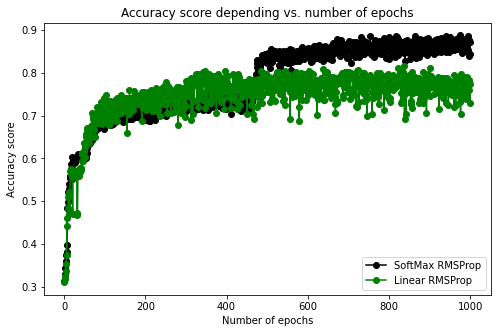

In [13]:
fig = plt.figure(figsize = (8, 5))
ax1 = fig.add_subplot(111)
x_epochs = [i for i in range(1, upper_epoch_bound + 1, 1)]
ax1.plot(x_epochs, accuracy_scores[0], '-ok', label="SoftMax RMSProp")
ax1.plot(x_epochs, accuracy_scores[1], '-og', label="Linear RMSProp")
plt.legend(loc="lower right")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy score")
plt.title("Accuracy score depending vs. number of epochs")
plt.show()

## 3. Xor3 dataset

In [14]:
xor3_train = pd.read_csv("../data/mio1/classification/xor3-training.csv")
xor3_test = pd.read_csv("../data/mio1/classification/xor3-test.csv")

# universal parameter setting
activation_functions = [Sigmoid, SoftMax]

n_layers = [2, 10, 2]
number_of_batches = 10
upper_epoch_bound = 1000

eta = 0.005

In [15]:
# Data preprocessing

x_test = xor3_test[["x", "y"]].to_numpy()
x_train = xor3_train[["x", "y"]].to_numpy()

y_test = xor3_test["c"] * 1
n_values = np.max(y_test) + 1
y_test = np.eye(n_values)[y_test.T]

y_train = xor3_train["c"] * 1
n_values = np.max(y_train) + 1
y_train = np.eye(n_values)[y_train.T]

In [16]:
# Neural network without softmax performance 

xor3 = MLP(n_layers, "gaussian", activation_functions, MSECostFunction, True)

initial_weights = rings3.weights.copy()
initial_biases = rings3.biases.copy()

In [17]:
# Neural network without softmax performance 

xor3 = MLP(n_layers, "gaussian", activation_functions, MSECostFunction, True)

initial_weights = xor3.weights.copy()
initial_biases = xor3.biases.copy()

accuracy_scores = [[], []]

idx = 0

while idx < upper_epoch_bound:

    xor3.trainWithRMSProp(x = x_train, y = y_train, eta = eta, epochs = 1, batches_num = number_of_batches, beta = 0.9)

    prediction = xor3.predict(x_test)
    prediction = np.argmax(prediction, axis = 1)
    
    accuracy_scores[0].append(accuracy_score(np.argmax(y_test, axis = 1), prediction))
    idx += 1

In [18]:
activation_functions = [Sigmoid, Linear]

xor3 = MLP(n_layers, "gaussian", activation_functions, MSECostFunction, False)

xor3.weights = initial_weights
xor3.biases = initial_biases

idx = 0

while idx < upper_epoch_bound:

    xor3.trainWithRMSProp(x = x_train, y = y_train, eta = eta, epochs = 1, batches_num = number_of_batches, beta = 0.9)

    prediction = xor3.predict(x_test)
    prediction = np.argmax(prediction, axis = 1)
    
    accuracy_scores[1].append(accuracy_score(np.argmax(y_test, axis = 1), prediction))
    idx += 1

### Results comparison

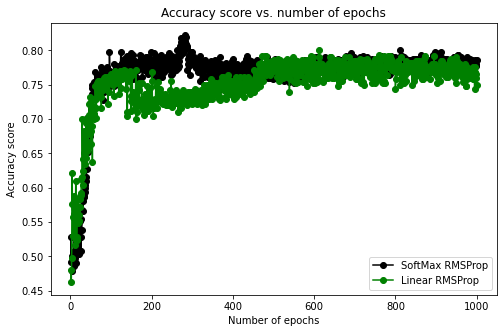

In [19]:
fig = plt.figure(figsize = (8, 5))
ax1 = fig.add_subplot(111)
x_epochs = [i for i in range(1, upper_epoch_bound + 1, 1)]
ax1.plot(x_epochs, accuracy_scores[0], '-ok', label="SoftMax RMSProp")
ax1.plot(x_epochs, accuracy_scores[1], '-og', label="Linear RMSProp")
plt.legend(loc="lower right")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy score")
plt.title("Accuracy score vs. number of epochs")
plt.show()